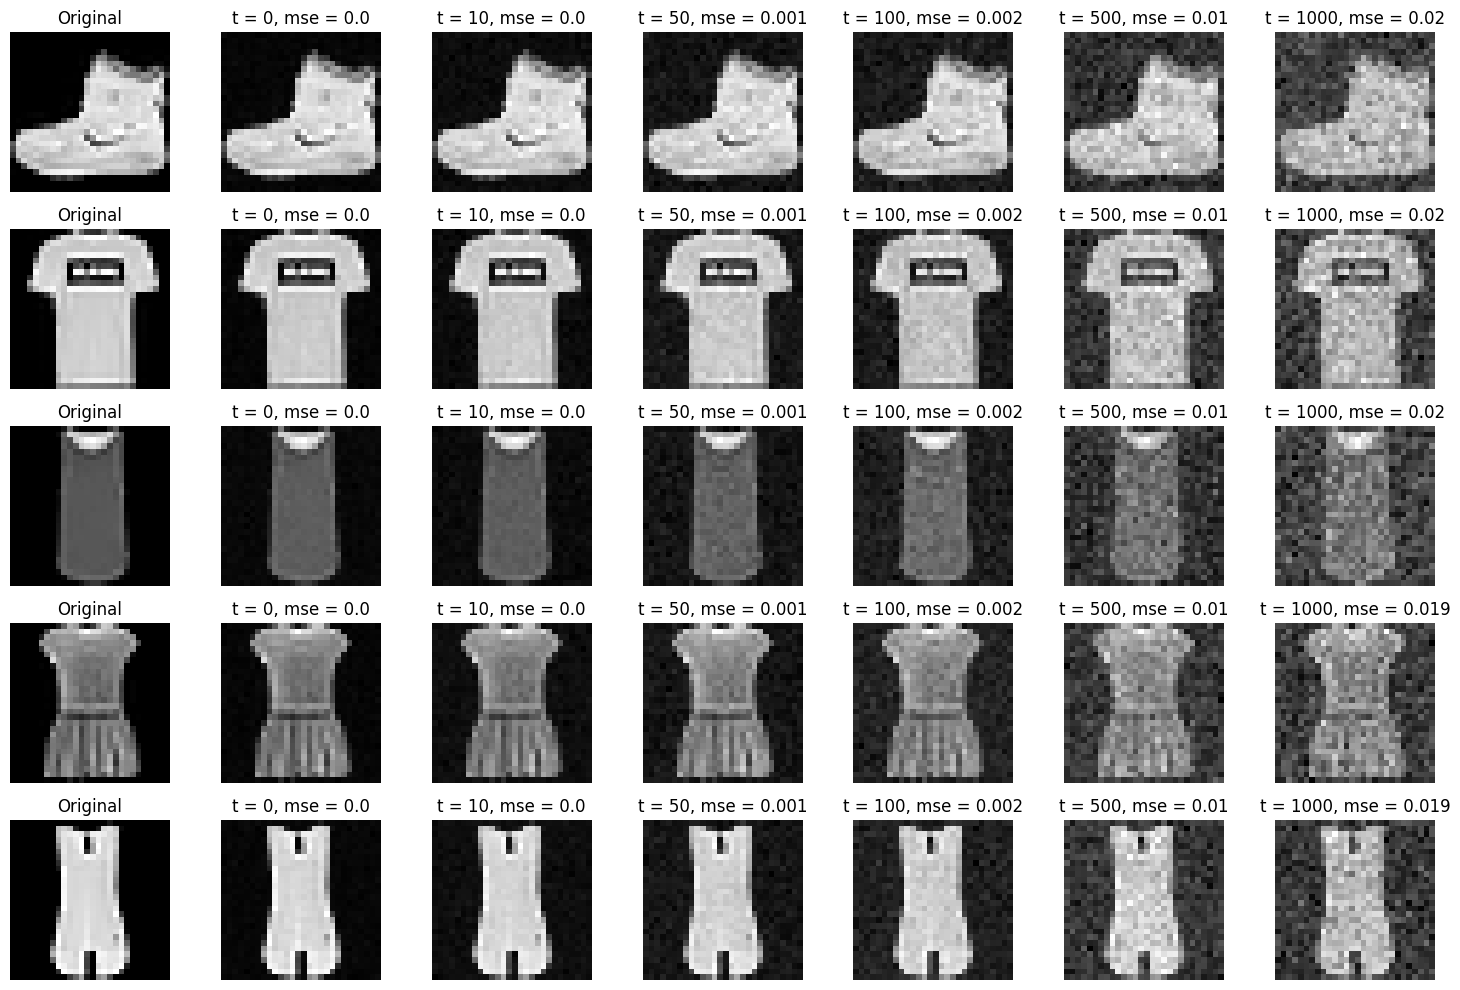

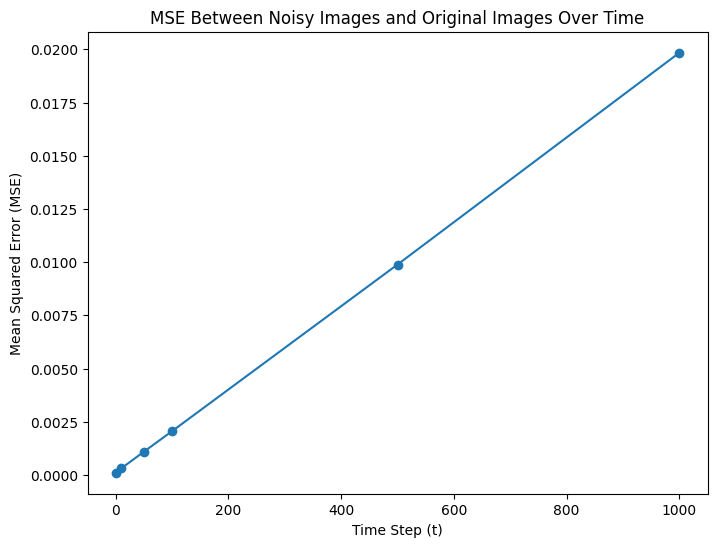

In [5]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

fashion_mnist = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# Select 5 images from the dataset
images = torch.stack([fashion_mnist[i][0] for i in range(5)])  # Shape: [5, 1, 28, 28]

# Set the variance schedule
def variance_schedule(t, beta_start=0.0001, beta_end=0.02, num_steps=1000):
    return beta_start + (beta_end - beta_start) * t / num_steps

# Forward diffusion process: adding Gaussian noise
def forward_diffusion(x, t):
    beta_t = torch.tensor(variance_schedule(t))  # Convert beta_t to a tensor
    noise = torch.randn_like(x) * torch.sqrt(beta_t)
    return x + noise

# Define time steps to visualize
time_steps = [0, 10, 50, 100, 500, 1000]

# Set up the plot grid
fig, axes = plt.subplots(len(images), len(time_steps) + 1, figsize=(15, 10))

# Mean squared error tracker
mse_values = []

# Visualize diffusion process for each selected image
for i, img in enumerate(images):
    # Plot original image in the first column
    axes[i, 0].imshow(img.squeeze(), cmap="gray")
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    # Apply forward diffusion at each time step
    for j, t in enumerate(time_steps):
        # Generate noisy image
        noisy_img = forward_diffusion(img, t)

        # Calculate MSE with respect to the original image
        mse = torch.nn.functional.mse_loss(noisy_img, img).item()
        mse_values.append((t, mse))

        # Plot the noisy image
        axes[i, j + 1].imshow(noisy_img.squeeze(), cmap="gray")
        axes[i, j + 1].set_title(f"t = {t}, mse = {round(mse,3)}")
        axes[i, j + 1].axis("off")

# Display the plot grid
plt.tight_layout()
plt.show()

# Calculate and plot the MSE trend over time
mse_by_time = {}
for t, mse in mse_values:
    if t not in mse_by_time:
        mse_by_time[t] = []
    mse_by_time[t].append(mse)

mse_avg = {t: np.mean(mse_by_time[t]) for t in mse_by_time}
plt.figure(figsize=(8, 6))
plt.plot(list(mse_avg.keys()), list(mse_avg.values()), marker='o')
plt.xlabel("Time Step (t)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE Between Noisy Images and Original Images Over Time")
plt.show()


In [ ]:
!pip install diffusers accelerate

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Generating sample with 100 steps...


  0%|          | 0/100 [00:00<?, ?it/s]

Generating sample with 50 steps...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating sample with 10 steps...


  0%|          | 0/10 [00:00<?, ?it/s]

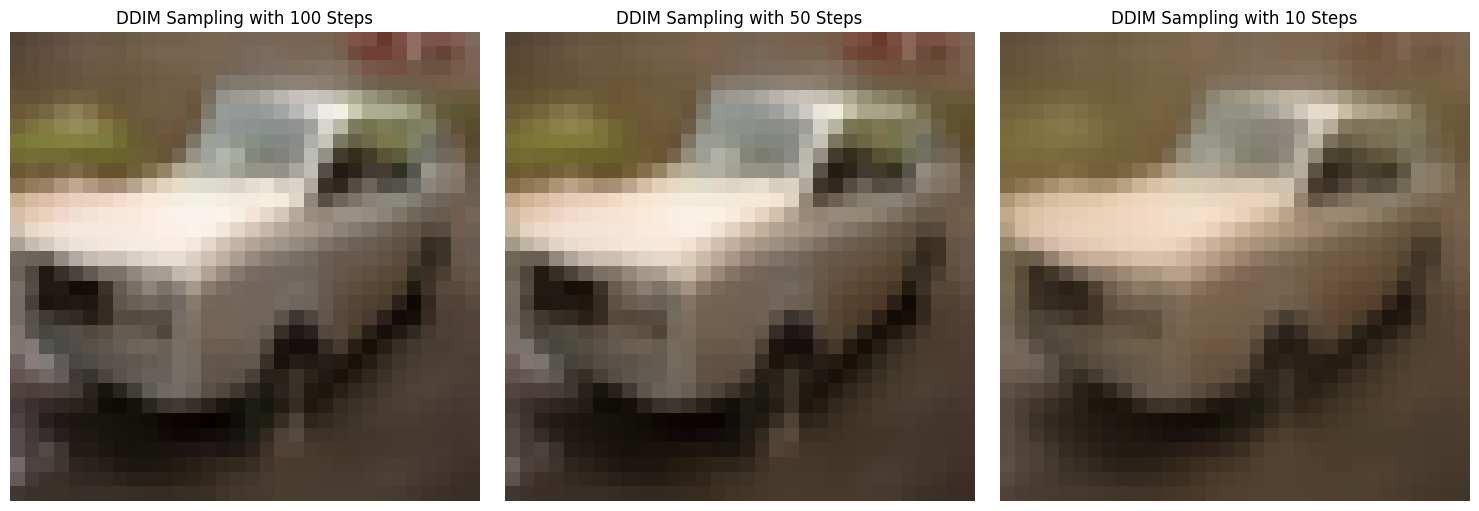

In [ ]:
from diffusers import DDIMPipeline
import torch
import matplotlib.pyplot as plt

# Load the DDIM pipeline with a pre-trained model (in this case, the CIFAR-10 model)
model_id = "google/ddpm-cifar10-32"
ddim = DDIMPipeline.from_pretrained(model_id)

# Define the different sampling steps for comparison
step_counts = [100, 50, 10]
images = {}

# Generate samples at each step count
for steps in step_counts:
    print(f"Generating sample with {steps} steps...")
    # Run the pipeline with the specified number of inference steps
    image = ddim(generator=torch.manual_seed(0), num_inference_steps=steps).images[0]
    images[steps] = image

# Plot the generated images for each step count
fig, axes = plt.subplots(1, len(step_counts), figsize=(15, 5))
for idx, steps in enumerate(step_counts):
    axes[idx].imshow(images[steps])
    axes[idx].set_title(f"DDIM Sampling with {steps} Steps")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [7]:
!git clone https://github.com/google/prompt-to-prompt.git
%cd prompt-to-prompt
import sys
sys.path.append('./')

Cloning into 'prompt-to-prompt'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 58 (delta 24), reused 18 (delta 18), pack-reused 25 (from 1)
Receiving objects: 100% (58/58), 33.06 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/prompt-to-prompt


In [8]:
import ptp_utils
import seq_aligner
from typing import Union, Tuple, List, Callable, Dict, Optional
import torch
import torch.nn.functional as nnf
from diffusers import DiffusionPipeline
import numpy as np
from IPython.display import display
from PIL import Image
import abc

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [9]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model_id = "CompVis/ldm-text2im-large-256"
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 5.
MAX_NUM_WORDS = 77
# load model and scheduler
ldm = DiffusionPipeline.from_pretrained(model_id).to(device)
tokenizer = ldm.tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

tokenizer/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/713 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.49G [00:00<?, ?B/s]

bert/config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

vqvae/config.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'timestep_values': None} were passed to DDIMScheduler, but are not 

In [14]:
class LocalBlend:

    def __call__(self, x_t, attention_store, step):
        k = 1
        maps = attention_store["down_cross"][:2] + attention_store["up_cross"][3:6]
        maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
        maps = torch.cat(maps, dim=1)
        maps = (maps * self.alpha_layers).sum(-1).mean(1)
        mask = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(maps, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.threshold)
        mask = (mask[:1] + mask).float()
        x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t

    def __init__(self, prompts: List[str], words: [List[List[str]]], threshold: float = .3):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        self.alpha_layers = alpha_layers.to(device)
        self.threshold = threshold


class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        h = attn.shape[0]
        attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0


class EmptyControl(AttentionControl):

    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn


class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        if attn.shape[1] <= 16 ** 2:  # avoid memory overhead
            key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


class AttentionControlEdit(AttentionStore, abc.ABC):

    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store, self.cur_step)
        return x_t

    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace

    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn

    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)


class AttentionRefine(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])


class AttentionReweight(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch.float32)
    for word in word_select:
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        for i in inds:
            equalizer[:, i] = values
    return equalizer

In [15]:
def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))


def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

In [16]:
def sort_by_eq(eq):

    def inner_(images):
        swap = 0
        if eq[-1] < 1:
            for i in range(len(eq)):
                if eq[i] > 1 and eq[i + 1] < 1:
                    swap = i + 2
                    break
        else:
             for i in range(len(eq)):
                if eq[i] < 1 and eq[i + 1] > 1:
                    swap = i + 2
                    break
        print(swap)
        if swap > 0:
            images = np.concatenate([images[1:swap], images[:1], images[swap:]], axis=0)

        return images
    return inner_


def run_and_display(prompts, controller, latent=None, run_baseline=True, callback:Optional[Callable[[np.ndarray], np.ndarray]] = None, generator=None):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False)
        print("results with prompt-to-prompt")
    images, x_t = ptp_utils.text2image_ldm(ldm, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator)
    if callback is not None:
        images = callback(images)
    ptp_utils.view_images(images)
    return images, x_t

  0%|          | 0/50 [00:00<?, ?it/s]

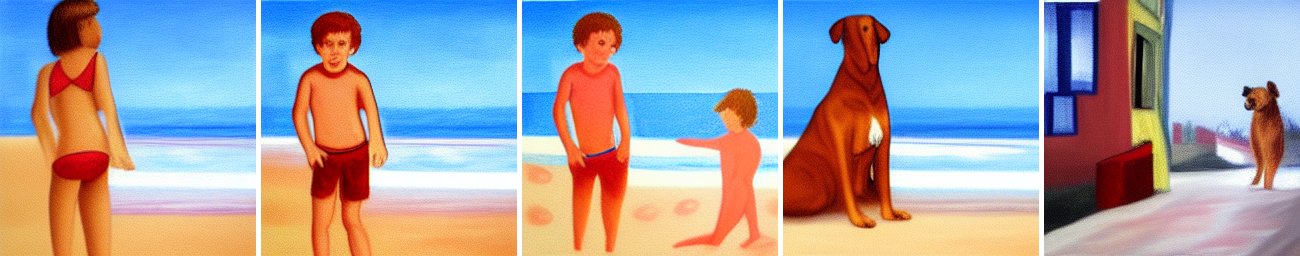

In [24]:
g_cpu = torch.Generator().manual_seed(888)
prompts = ["A painting of a girl on the beach",
           "A painting of a boy on the beach",
           "A painting of boy and girl on beach",
           "A painting of a dog on the beach",
           "A painting of a dog on the street",
          ]
controller = AttentionReplace(prompts, NUM_DIFFUSION_STEPS, cross_replace_steps=.8, self_replace_steps=.2)
_ = run_and_display(prompts, controller, latent=x_t, run_baseline=False)

In [ ]:
""